# CSC 421 Assignment 1
### Taylor Koch
### V00809341
## Knn

This notebook imports the CIFAR-10 image dataset and separates the data into two sets containing 50000 train / 10000 test images. The data is not shuffled, since it was not required to be (except in the 5-fold validation section). The Knn machine learning algorithm is then used to train on the 50000 train images, and classify on the 10000 test images (using various values of k). The accuracies of the predictions for each k value are calculated and compared.

#### Import statements

In [1]:
import matplotlib.pyplot as plt  #Used for plotting different k values, as well as displaying images during testing
import numpy as np
import torch                     #torch and other libraries are only being used to download/import the cifar data
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose
from collections import Counter
import cv2                       #Used for displaying images during testing

In [2]:
import ssl                       #for resolving a known certificate error with downloading CIFAR-10 in torchvision
ssl._create_default_https_context = ssl._create_unverified_context

The ssl code above is for resolving a known certificate error with CIFAR-10 in torchvision 

#### RGB values for Grayscale conversion

In [3]:
RED = 0.299
GREEN = 0.587
BLUE = 0.114

#### Seed value for shuffling data

In [4]:
seedval = 2022 #seed used in k-fold validation

#### Importing and partitioning data into test and train datasets

The data is imported and stored in two arrays. Each image of the dataset is a 32x32 image, and each pixel has BGR values.

In [5]:
train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
X_train = train_dataset.data
y_train = np.array(train_dataset.targets)
X_test = test_dataset.data
y_test = np.array(test_dataset.targets)
classes = train_dataset.classes

In [7]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


#### Function Definitions

##### Grayscale conversion function to be performed on every pixel when called in preProcess function

In [8]:
def toBWArray(itemarray):
    global RED,BLUE,GREEN
    val = np.uint8(np.dot(itemarray, [BLUE,GREEN,RED]))
    return val

##### Pre-processing of each image. Flattens the array, converts it to grayscale, and scales each pixel value between 0-1.

In [9]:
def preProcess(itemarray):
    arrcopy = np.empty((len(itemarray), 32, 32, 3))
    np.copyto(arrcopy, itemarray)
    arrcopy = arrcopy.reshape((len(itemarray), 1024, 3))
    bwArray = np.empty((len(itemarray),1024), np.uint8)
    for i in range(len(itemarray)):
        bwArray[i] = toBWArray(arrcopy[i])
    bwArray = bwArray / 256
    return bwArray

##### Distance computation. Calculates the distances between every image in X_test and every image in X_train. In this case, outputs an array of size (10000, 50000)

In [10]:
def computeDist(X_train, X_test):
    distance_array = np.empty((len(X_test),len(X_train)), np.float32)
    for n in range(len(X_test)):
        #print(f'calculating distances for image {n}')
        results_array = np.empty((len(X_train)))
        for i in range(len(X_train)):
            results_array[i] = np.sqrt(np.sum(np.square(X_train[i] - X_test[n])))
        distance_array[n] = results_array
    return distance_array

##### User-facing function used to "train" the dataset. It really just calls computeDist.

In [11]:
def trainThis(X_train, y_train, X_test):
    distance_array = computeDist(X_train, X_test)
    return distance_array

##### This function uses global values of k to take the k-closest X_train images from the corresponding distance list for each image of X_test. It then takes the indexes of those closest images, counts the most common occurance, and stores that value in a results_array whose index corresponds to the index of X_test

In [12]:
def classifyThis(distance_array, y_train):
    global k
    results_array = np.empty(len(distance_array), np.uint8)
    for n in range(len(results_array)):
        classeslist = np.empty(k)
        distancesortedindexes = np.argsort(distance_array[n])
        for i in range(len(classeslist)):
            classeslist[i] = y_train[distancesortedindexes[i]]
        c = Counter(classeslist)
        results_array[n] = c.most_common(1)[0][0]
    return results_array

##### Compares the answers of the test set to the predicted set and returns the accuracy of the predicted set

In [13]:
def evalThis(results_array, y_test):
    val = np.sum(results_array == y_test) / len(y_test)
    return val





#### Computation

Both the X_train and X_test arrays are preprocessed.

In [14]:
X_train_proc = preProcess(X_train)
print('X_train preprocessed')
X_test_proc = preProcess(X_test)
print('X_test preprocessed')

X_train preprocessed
X_test preprocessed


The arrays are now reshaped, converted to grayscale, and scaled

In [15]:
print(X_train_proc)

[[0.23828125 0.17578125 0.1796875  ... 0.6796875  0.43359375 0.34765625]
 [0.69140625 0.52734375 0.39453125 ... 0.52734375 0.53515625 0.53515625]
 [0.99609375 0.98828125 0.98828125 ... 0.32421875 0.32421875 0.328125  ]
 ...
 [0.6953125  0.69921875 0.703125   ... 0.21875    0.18359375 0.1328125 ]
 [0.84765625 0.83203125 0.828125   ... 0.703125   0.71875    0.71875   ]
 [0.90234375 0.93359375 0.93359375 ... 0.6875     0.63671875 0.6328125 ]]


In [16]:
print(X_train_proc.shape)

(50000, 1024)


In [17]:
print(X_test_proc.shape)

(10000, 1024)


Distance array is calculated for every image in X_test.

In [18]:
distance_array = trainThis(X_train_proc, y_train, X_test_proc)

In [19]:
print(distance_array)

[[ 6.6806     8.814243  12.311892  ... 11.074615  11.5746565  9.574177 ]
 [13.959751  11.588673   9.104533  ... 10.0869     8.199101  11.366525 ]
 [10.890447   9.228642   8.495009  ...  8.555114   7.6023664  9.010739 ]
 ...
 [ 9.362952  13.998307  17.503193  ... 14.580839  18.182764  14.695854 ]
 [ 6.9926567  9.95874   13.610982  ... 12.150267  12.8435955 10.490734 ]
 [ 8.088964   9.4295435 11.073403  ...  9.540804  11.611938   8.405117 ]]


In [20]:
k = 3
results_array = classifyThis(distance_array, y_train)
k3 = evalThis(results_array, y_test)
print(k3)
k = 5
results_array = classifyThis(distance_array, y_train)
k5 = evalThis(results_array, y_test)
print(k5)
k = 7
results_array = classifyThis(distance_array, y_train)
k7 = evalThis(results_array, y_test)
print(k7)
k = 11
results_array = classifyThis(distance_array, y_train)
k11 = evalThis(results_array, y_test)
print(k11)

0.3205
0.318
0.317
0.3086


### Accuracy Chart

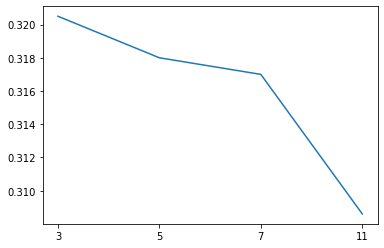

In [21]:
vals = {'3':k3, '5':k5, '7':k7, '11':k11}
plt_x = list(vals.keys())
plt_y = list(vals.values())
plt.plot(plt_x, plt_y)

As we can see, k = 3 has the highest accuracy at around 32%

## 5-fold Validation

In [22]:
def fiveFoldVal(X_train, X_test, y_train, y_test):
    global k
    folds = 5
    np.random.seed(seedval)
    
    X_set_OG = np.concatenate((X_train, X_test))
    y_set_OG = np.concatenate((y_train, y_test))
    
    X_set_OG = preProcess(X_set_OG)
    
    indices = np.arange(X_set_OG.shape[0])
    np.random.shuffle(indices)
    X_set = X_set_OG[indices]
    y_set = y_set_OG[indices]
    
    #size reduction for testing
    #X_set = X_set[:1000]
    #y_set = y_set[:1000]
    
    #This is assuming (X_set = y_set = 60000) is divisible by (folds = 5)
    #I didn't bother to write the case where it isn't
    subset_size = int(X_set.shape[0] / folds)
    
    X_sets = np.empty((folds, subset_size, 1024), np.float32)
    for i in range(folds):
        X_sets[i] = X_set[(i * subset_size):((i+1) * subset_size)]

    y_sets = np.empty((folds, subset_size), np.uint8)
    for i in range(folds):
        y_sets[i] = y_set[(i * subset_size):((i+1) * subset_size)]
        
    accuracies = np.empty((folds, 4), np.float32)
        
    for i in range(folds):
        print(f'Fold: {(i+1)}')
        X_test = X_sets[i]
        y_test = y_sets[i]
        
        X_train = np.empty(shape=[0, 1024], dtype=np.float32)
        y_train = np.empty(shape=[0], dtype=np.uint8)
        
        for j in range(folds):
            if(j!=i):
                X_train = np.append(X_train, X_sets[j], axis=0)
                y_train = np.append(y_train, y_sets[j])
        
        distance_array = trainThis(X_train, y_train, X_test)
        
        k = 3
        results_array = classifyThis(distance_array, y_train)
        k3 = evalThis(results_array, y_test)
        accuracies[i][0] = k3
        print(k3)
        
        k = 5
        results_array = classifyThis(distance_array, y_train)
        k5 = evalThis(results_array, y_test)
        accuracies[i][1] = k5
        print(k5)
        
        k = 7
        results_array = classifyThis(distance_array, y_train)
        k7 = evalThis(results_array, y_test)
        accuracies[i][2] = k7
        print(k7)
        
        k = 11
        results_array = classifyThis(distance_array, y_train)
        k11 = evalThis(results_array, y_test)
        accuracies[i][3] = k11
        print(k11)
        print()
        print()
    return accuracies

In [23]:
accuracies = fiveFoldVal(X_train, X_test, y_train, y_test)

Fold: 1
0.3155
0.31983333333333336
0.31566666666666665
0.3145


Fold: 2
0.31475
0.3134166666666667
0.3125
0.3075833333333333


Fold: 3
0.31908333333333333
0.3205
0.31758333333333333
0.3144166666666667


Fold: 4
0.30866666666666664
0.31266666666666665
0.3119166666666667
0.3085833333333333


Fold: 5
0.31908333333333333
0.31575
0.31333333333333335
0.30641666666666667




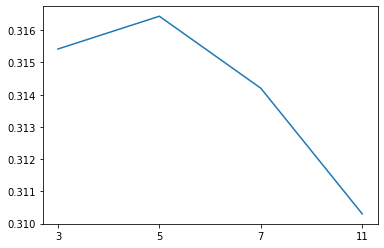

In [24]:
avg_k3 = np.mean(accuracies[:,0])
avg_k5 = np.mean(accuracies[:,1])
avg_k7 = np.mean(accuracies[:,2])
avg_k11 = np.mean(accuracies[:,3])
vals = {'3':avg_k3, '5':avg_k5, '7':avg_k7, '11':avg_k11}
plt_x = list(vals.keys())
plt_y = list(vals.values())
plt.plot(plt_x, plt_y)

After performing 5-fold validation, it is clear that the best value of k for Knn in this model is actually k = 5, with around 31.65% accuracy

## Image Printing

This section was used for testing and can be ignored.

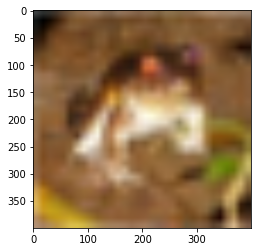

In [25]:
IMGNUM = 0
#img_colored = cv2.cvtColor(X_train[IMGNUM], cv2.COLOR_BGR2RGB)
#img_resized = cv2.resize(img_colored, (400,400))
#plt.imshow(img_resized)

#X_train = X_train.reshape((50000,32,32))
#print(X_train)
img_resized = cv2.resize(X_train[IMGNUM],(400,400))
#img_resized2 = cv2.resize(X_train_proc[IMGNUM],(400,400))

plt.imshow(img_resized)
plt.show()
#plt.imshow(img_resized2, cmap='gray', vmin=0, vmax=255)
#plt.show()